In [34]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import GridSearchCV

In [35]:
!pip install tensorflow


In [36]:
import pandas as pd

data = pd.read_csv('train.csv')


In [37]:
import numpy as np
from sklearn.model_selection import train_test_split

# Function to load a single CIFAR-10 batch file
def load_cifar10_batch(filename):
    label_byte = 1
    image_bytes = 3 * 1024  # 3 channels * 32 * 32
    single_record = label_byte + image_bytes

    with open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)

    data = data.reshape(-1, single_record)
    labels = data[:, :label_byte].flatten()
    images = data[:, label_byte:].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Converting this to HWC format

    return images, labels



In [38]:
# Function to load all CIFAR-10 batches
def load_all_cifar10_batches():
    all_images = []
    all_labels = []

#The data is in batches and in binary files 
    batch_paths = [
        'data_batch_1.bin',
        'data_batch_2.bin',
        'data_batch_3.bin',
        'data_batch_4.bin',
        'data_batch_5.bin'
    ]

    for batch_path in batch_paths:
        images, labels = load_cifar10_batch(batch_path)
        all_images.append(images)
        all_labels.append(labels)

    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_images, all_labels

# Loading all batches
all_images, all_labels = load_all_cifar10_batches()

# Loading the test batch
test_images, test_labels = load_cifar10_batch('test_batch.bin')

# Splitting all_images and all_labels into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)



In [39]:
# Displaying the shape of the training, validation and test datasets to confirm the Split

print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Val data shape:", x_val.shape)
print("Val labels shape:", y_val.shape)
print("Test data shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)


Training data shape: (40000, 32, 32, 3)
Training labels shape: (40000,)
Val data shape: (10000, 32, 32, 3)
Val labels shape: (10000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


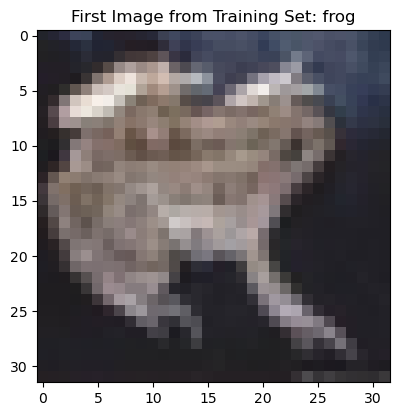

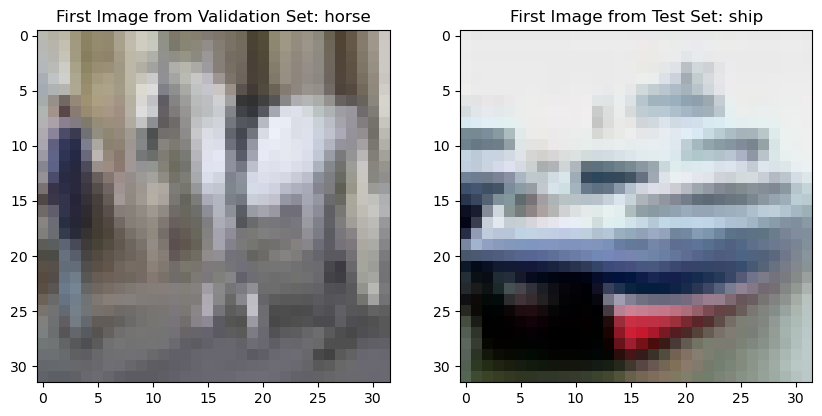

In [40]:
#Checking whether the images are read with appropriate labels

# CIFAR-10 class labels
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Display an image from the training set
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title(f"First Image from Training Set: {cifar10_labels[y_train[0]]}")
plt.imshow(x_train[0])

# Display an image from the validation set
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title(f"First Image from Validation Set: {cifar10_labels[y_val[0]]}")
plt.imshow(x_val[0])

# Displaying an image from the test set
plt.subplot(1, 2, 2)
plt.title(f"First Image from Test Set: {cifar10_labels[test_labels[1]]}")
plt.imshow(test_images[1])

plt.show()

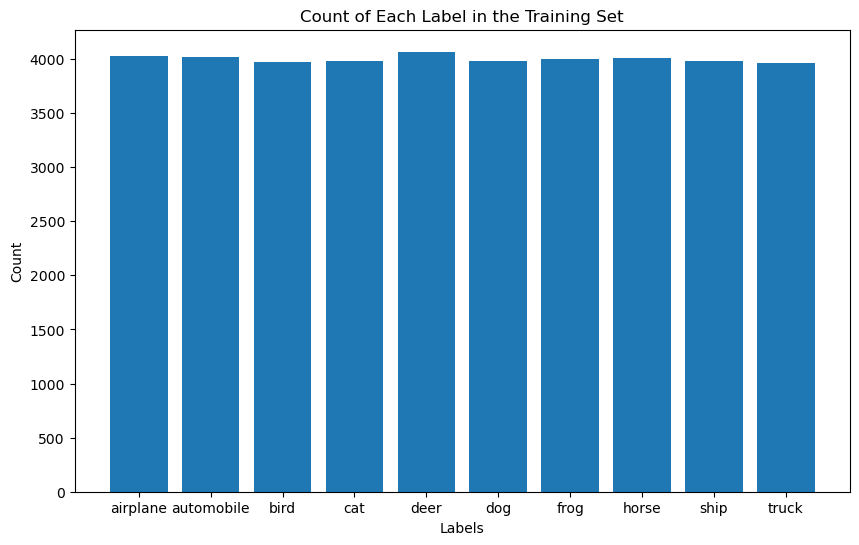

In [41]:
unique_labels, counts = np.unique(y_train, return_counts=True)


cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, tick_label=[cifar10_labels[i] for i in unique_labels])
plt.title('Count of Each Label in the Training Set')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

# Implementing the baseline model


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#Function to create the baseline structure

def build_baseline_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # Second convolutional layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Third convolutional layer
    model.add(Conv2D(128, (3, 3), activation='relu'))

    # Flattening the 3D output to 1D tensor for a fully connected layer
    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(128, activation='relu'))
# Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Creating the baseline model
baseline_model = build_baseline_cnn_model()

# Compiling the model
baseline_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Model summary to view the architecture
baseline_model.summary()

C:\Users\ruzar\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

# data preprocessing model

In [45]:
# Scaling and Normalizing the image data
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [46]:
# Train the model
history = baseline_model.fit(x_train, y_train,
                             epochs=10,
                             batch_size=32,
                             validation_data=(x_val, y_val))


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.3440 - loss: 1.7630 - val_accuracy: 0.5415 - val_loss: 1.2637
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.5817 - loss: 1.1851 - val_accuracy: 0.6335 - val_loss: 1.0507
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.6520 - loss: 0.9941 - val_accuracy: 0.6423 - val_loss: 1.0120
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.6965 - loss: 0.8624 - val_accuracy: 0.6840 - val_loss: 0.9068
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 69s 29ms/step - accuracy: 0.7354 - loss: 0.7587 - val_accuracy: 0.6931 - val_loss: 0.9031
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 35ms/step - accuracy: 0.7654 - loss: 0.6661 - val_accuracy: 0.7112 - val_loss: 0.8480
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 36ms/step - accuracy: 0.7924 - loss: 0.5837 - val_accuracy: 0.7118 - val_loss: 0.8669
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - accuracy: 0.8162 -

In [60]:
def plot_training_curves(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plotting Training and Validation Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

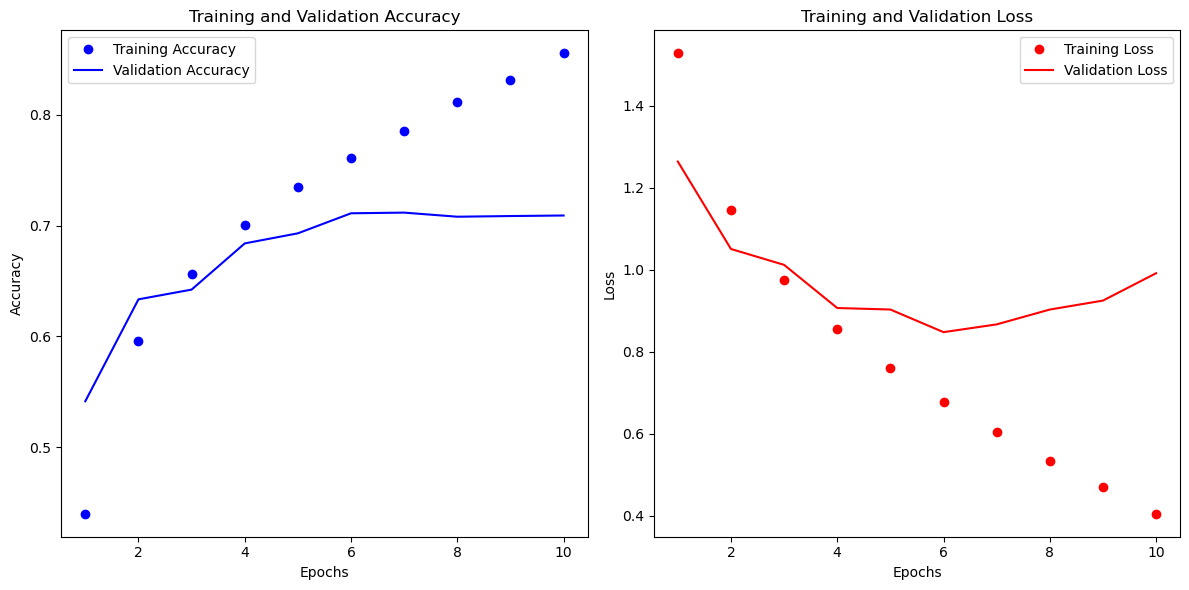

In [62]:
plot_training_curves(history)

In [64]:
# Evaluate the baseline model on the test data

baseline_test_loss, baseline_test_accuracy = baseline_model.evaluate(test_images, test_labels)

# Print the test loss and accuracy for the baseline model
print("Baseline Test Loss:", baseline_test_loss)
print("Baseline Test Accuracy:", baseline_test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7067 - loss: 0.9798
Baseline Test Loss: 1.0090372562408447
Baseline Test Accuracy: 0.7027999758720398


In [70]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the data generator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# Fit the data generator to the training data
datagen.fit(x_train)

# Train the model using the augmented data
history2 = baseline_model.fit(datagen.flow(x_train, y_train, batch_size=32),
                             epochs=10,
                             validation_data=(x_val, y_val))

Epoch 1/10


C:\Users\ruzar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 69s 55ms/step - accuracy: 0.7357 - loss: 0.7544 - val_accuracy: 0.7266 - val_loss: 0.8285
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 52ms/step - accuracy: 0.7457 - loss: 0.7271 - val_accuracy: 0.7263 - val_loss: 0.8341
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 69s 55ms/step - accuracy: 0.7463 - loss: 0.7335 - val_accuracy: 0.7484 - val_loss: 0.7435
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 53ms/step - accuracy: 0.7467 - loss: 0.7214 - val_accuracy: 0.7601 - val_loss: 0.7227
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 68s 54ms/step - accuracy: 0.7499 - loss: 0.7114 - val_accuracy: 0.7461 - val_loss: 0.7659
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 68s 54ms/step - accuracy: 0.7507 - loss: 0.7092 - val_accuracy: 0.7665 - val_loss: 0.6886
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 68s 54ms/step - accuracy: 0.7520 - loss: 0.6983 - val_accuracy: 0.7620 - val_loss: 0.7244
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 68s 54ms/step - accuracy: 0.7563 - loss: 0.69

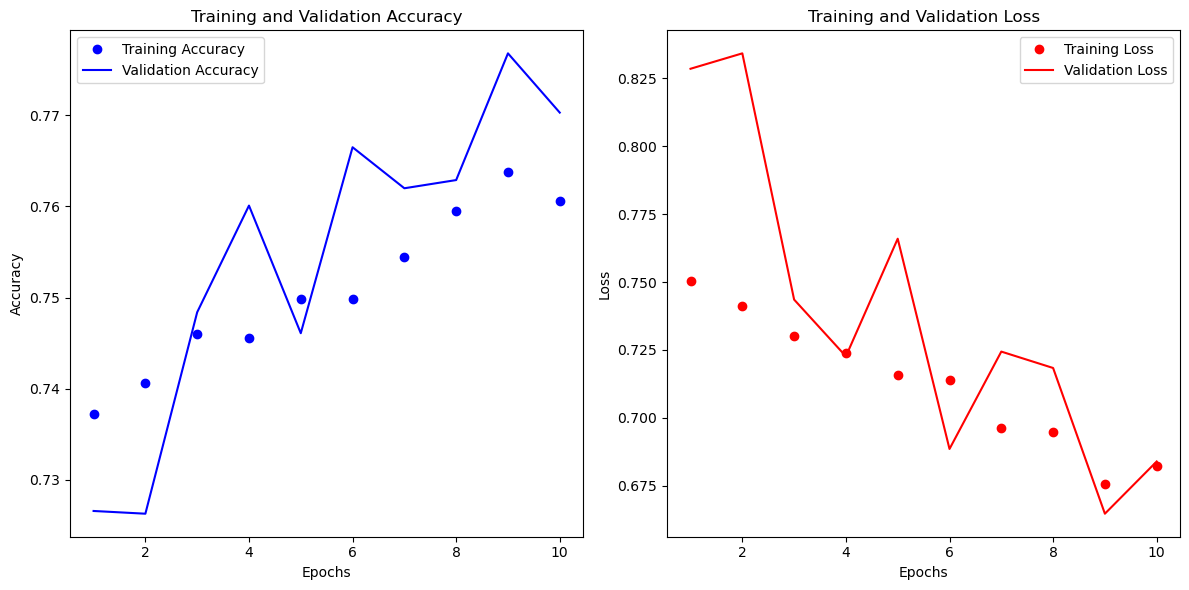

In [72]:

plot_training_curves(history2)

# Implementing Grid search to find best hyperparameters

In [76]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define hyperparameter grid
optimizers = ['SGD', 'Adam']
epochs = [10, 20]
batch_sizes = [32, 64]

# Store results
best_accuracy = 0.0
best_params = {}

# Loop over each hyperparameter combination
for optimizer in optimizers:
    for epoch in epochs:
        for batch_size in batch_sizes:
            print(f"Training with optimizer={optimizer}, epochs={epoch}, batch_size={batch_size}")

            # Create and compile model
            model = Sequential([
                Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
                MaxPooling2D((2, 2)),
                Conv2D(64, (3, 3), activation='relu'),
                MaxPooling2D((2, 2)),
                Conv2D(128, (3, 3), activation='relu'),
                MaxPooling2D((2, 2)),
                Flatten(),
                Dense(128, activation='relu'),
                Dense(10, activation='softmax')  # 10 classes for CIFAR-10
            ])
            model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            # Train model
            history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epoch, validation_data=(x_val, y_val))

            # Evaluate model
            loss, accuracy = model.evaluate(x_val, y_val, verbose=0)
            print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

            # Update best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'optimizer': optimizer, 'epochs': epoch, 'batch_size': batch_size}

print("Best parameters found:", best_params)
print("Best accuracy found:", best_accuracy)

Training with optimizer=SGD, epochs=10, batch_size=32


C:\Users\ruzar\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ruzar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 71s 56ms/step - accuracy: 0.1629 - loss: 2.2282 - val_accuracy: 0.2663 - val_loss: 1.9892
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 77s 52ms/step - accuracy: 0.2783 - loss: 1.9753 - val_accuracy: 0.3394 - val_loss: 1.8118
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 77s 48ms/step - accuracy: 0.3557 - loss: 1.7847 - val_accuracy: 0.4126 - val_loss: 1.6230
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 67s 53ms/step - accuracy: 0.4073 - loss: 1.6444 - val_accuracy: 0.4534 - val_loss: 1.5145
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 69s 55ms/step - accuracy: 0.4342 - loss: 1.5728 - val_accuracy: 0.4819 - val_loss: 1.4404
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 67s 53ms/step - accuracy: 0.4600 - loss: 1.5035 - val_accuracy: 0.4929 - val_loss: 1.4000
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 67s 53ms/step - accuracy: 0.4796 - loss: 1.4522 - val_accuracy: 0.5239 - val_loss: 1.3471
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 66s 53ms/step - accuracy: 0.5021 -

In [78]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout

# Creating a ResNet50 model with pre-trained weights from ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


for layer in base_model.layers[-10:]:
    layer.trainable = True

# Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)  # Add dropout with rate of 0.3
predictions = Dense(10, activation='softmax')(x)  # 10 classes for CIFAR-10

# Create the final model
resnet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Show the model architecture
resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)   │ (None, 32, 32, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 38, 38, 3)         │               0 │ input_layer_11[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 16, 16, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 16, 16, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 16, 16, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 18, 18, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 8, 8, 64)          │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 8, 8, 64)          │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 8, 8, 64)          │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 8, 8, 64)          │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 8, 8, 64)          │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 8, 8, 64)          │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 8, 8, 64)          │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 8, 8, 256)         │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 8, 8, 256)         │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,641,930 (94.00 MB)

 Trainable params: 24,588,810 (93.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [80]:
# Training the ResNet model
history = resnet_model.fit(x_train, y_train,
                           epochs=10,
                           batch_size=64,
                           validation_data=(x_val, y_val),
                           verbose=1)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1333s 2s/step - accuracy: 0.4702 - loss: 1.7355 - val_accuracy: 0.2105 - val_loss: 2.8757
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1279s 2s/step - accuracy: 0.6864 - loss: 0.9400 - val_accuracy: 0.6147 - val_loss: 1.2384
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1233s 2s/step - accuracy: 0.7062 - loss: 0.8671 - val_accuracy: 0.4617 - val_loss: 2.0092
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1219s 2s/step - accuracy: 0.6821 - loss: 0.9309 - val_accuracy: 0.5015 - val_loss: 2.0381
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1264s 2s/step - accuracy: 0.7402 - loss: 0.7783 - val_accuracy: 0.2248 - val_loss: 2.6432
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1308s 2s/step - accuracy: 0.6238 - loss: 1.0774 - val_accuracy: 0.4123 - val_loss: 1.6371
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1284s 2s/step - accuracy: 0.7117 - loss: 0.8443 - val_accuracy: 0.2350 - val_loss: 2.3635
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1279s 2s/step - accuracy: 0.7365 - loss: 0.7710 - 

In [82]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  # Add a Dropout layer for regularization
predictions = Dense(10, activation='softmax')(x)  # Assuming 10 classes for CIFAR-10

# Creating the final model
modified_resnet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with -->a smaller learning rate
modified_resnet_model.compile(optimizer=Adam(learning_rate=0.0001),
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Summary of the model architecture
modified_resnet_model.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)   │ (None, 32, 32, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 38, 38, 3)         │               0 │ input_layer_11[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 16, 16, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 16, 16, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 16, 16, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 18, 18, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 8, 8, 64)          │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 8, 8, 64)          │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 8, 8, 64)          │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 8, 8, 64)          │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 8, 8, 64)          │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 8, 8, 64)          │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 8, 8, 64)          │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 8, 8, 256)         │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 8, 8, 256)         │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,641,930 (94.00 MB)

 Trainable params: 24,588,810 (93.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [84]:
history = modified_resnet_model.fit(x_train, y_train,
                           epochs=10,
                           batch_size=64,
                           validation_data=(x_val, y_val),
                           verbose=1)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1351s 2s/step - accuracy: 0.6412 - loss: 1.8261 - val_accuracy: 0.7575 - val_loss: 1.0961
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1237s 2s/step - accuracy: 0.7970 - loss: 0.9484 - val_accuracy: 0.7682 - val_loss: 0.9733
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1254s 2s/step - accuracy: 0.8243 - loss: 0.7955 - val_accuracy: 0.7764 - val_loss: 0.9204
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1251s 2s/step - accuracy: 0.8507 - loss: 0.6779 - val_accuracy: 0.7750 - val_loss: 0.8927
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1271s 2s/step - accuracy: 0.8725 - loss: 0.5765 - val_accuracy: 0.7826 - val_loss: 0.8608
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1238s 2s/step - accuracy: 0.8932 - loss: 0.4894 - val_accuracy: 0.7825 - val_loss: 0.8527
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1283s 2s/step - accuracy: 0.9088 - loss: 0.4091 - val_accuracy: 0.7793 - val_loss: 0.8708
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1114s 2s/step - accuracy: 0.9254 - loss: 0.3357 - 

In [86]:
# Evaluate the model on the test set
test_loss, test_accuracy = modified_resnet_model.evaluate(test_images, test_labels, verbose=0)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss: 1.0105928182601929, Test Accuracy: 0.7710999846458435
